<a href="https://colab.research.google.com/github/LuisEduardoRB/EDP-II/blob/main/Segundo_Examen_Sistemas_Financieros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# BLOQUE 0 – Configuración general y variable HOY

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


# Variable central: fecha de 'HOY'
# ------------------------------------------------------------------
# VARIABLE CLAVE:
# - HOY define el "presente" para TODO el análisis.
#   Desde aquí se calculan los rangos de 2 y 3 años hacia atrás y la proyección hacia adelante.
#
# Puedes cambiarla a cualquier fecha:
#   HOY = pd.Timestamp(2023, 12, 31)
#   HOY = pd.Timestamp("2024-06-01")
#
# Si la cambias, automáticamente se actualizan:
#   - start_3y, start_2y, end_hist, end_2y_forward
HOY = pd.Timestamp(2023, 12, 8)  # <-- cámbiala aquí si quieres otro "hoy"

# Fechas derivadas
# ------------------------------------------------------------------
# Todas dependen de HOY:
#
# - start_3y: 3 años antes de HOY (para análisis de 3 años).
# - start_2y: 2 años antes de HOY (para análisis de 2 años).
# - end_hist: fecha final del histórico (igual a HOY).
#
# Si cambias HOY o cambias "years=3" / "years=2", modificas el horizonte histórico.
start_3y = HOY - pd.DateOffset(years=3)   # 3 años antes de HOY
start_2y = HOY - pd.DateOffset(years=2)   # 2 años antes de HOY
end_hist = HOY                            # hasta HOY

# Fechas para proyección 2 años hacia adelante
# ------------------------------------------------------------------
# end_2y_forward: fecha futura hasta donde vas a proyectar (por ejemplo, en Monte Carlo o señales).
# Puedes cambiar el horizonte:
#   - pd.DateOffset(years=1)
#   - pd.DateOffset(months=6)
end_2y_forward = HOY + pd.DateOffset(years=2)

# Tickers elegidos
# ------------------------------------------------------------------
# VARIABLE CLAVE:
# - tickers: lista de activos que usas en TODO el análisis.
#   - [ "NVDA", "KO", "JPM" ] en este caso.
#
# Puedes añadir o cambiar activos:
#   tickers = ["AAPL", "MSFT"]
#   tickers = ["NVDA", "KO", "JPM", "TSLA"]
#
# OJO:
# - Si cambias la cantidad de tickers, también tienes que ajustar:
#   - el vector de pesos 'weights' más adelante
#   - algunos gráficos (número de subplots, etc.).
tickers = ["RKLB", "UPWK", "WDFC"]

# Función auxiliar para descargar precios ajustados
# ------------------------------------------------------------------
# get_adj_close(symbols, start, end):
#
# PARÁMETROS:
# - symbols:
#     * Puede ser:
#         - Un string: "AAPL", "^GSPC", "^IRX", etc.
#         - Una lista de strings: ["NVDA", "KO", "JPM"]
# - start:
#     * Fecha inicial del período que quieres descargar (start_2y, start_3y, start_signals, etc.)
# - end:
#     * Fecha final (end_hist, end_2y_forward, etc.)
#
# Internamente:
# - yf.download(...) baja datos OHLCV.
# - auto_adjust=False → los precios ajustados (por dividendos/splits) se toman de "Adj Close".
def get_adj_close(symbols, start, end):
    data = yf.download(symbols, start=start, end=end, auto_adjust=False)
    adj_close_data = data["Adj Close"]

    if isinstance(adj_close_data, pd.Series):
        # Caso 1: un solo símbolo -> yfinance regresa una Serie.
        # La convertimos a DataFrame con el nombre del símbolo como columna.
        return adj_close_data.to_frame(name=symbols)
    elif isinstance(adj_close_data, pd.DataFrame):
        # Caso 2: múltiples símbolos -> ya viene como DataFrame.
        # Lo regresamos tal cual.
        return adj_close_data
    else:
        # Caso raro: tipo inesperado.
        raise TypeError(f"Unexpected type for 'Adj Close' data: {type(adj_close_data)}")

In [51]:
# BLOQUE 2 – Pregunta 3: Datos de los últimos 3 años

# Descarga de precios ajustados de los últimos 3 años
# - tickers: lista de símbolos de las acciones/activos a descargar (por ejemplo ["AAPL", "MSFT"])
# - start_3y: fecha inicial de la serie histórica de 3 años (por ejemplo "2022-01-01")
# - end_hist: fecha final de la serie histórica (por ejemplo "2025-01-01")
#   Suele ser la fecha más reciente disponible o la fecha de corte del análisis.
prices_3y = get_adj_close(tickers, start_3y, end_hist)

# Ordenar por fecha por si acaso
# Nos aseguramos de que el índice temporal (las fechas) esté ordenado de menor a mayor,
# porque algunos cálculos de series de tiempo (como pct_change) suponen un orden cronológico.
prices_3y = prices_3y.sort_index()

# Cálculo de rendimientos diarios simples
# pct_change():
#   - Por defecto calcula el cambio porcentual respecto al periodo anterior (periods=1).
#   - Es decir, return_t = (price_t / price_{t-1}) - 1.
# dropna():
#   - Elimina las primeras filas que quedan como NaN porque no hay precio anterior
#     para calcular el primer rendimiento, y cualquier otra observación vacía que aparezca.
returns_3y = prices_3y.pct_change().dropna()

print("Primeras filas de precios (3 años):")
print(prices_3y.head())

print("\nPrimeras filas de rendimientos diarios (3 años):")
print(returns_3y.head())


[*********************100%***********************]  3 of 3 completed

Primeras filas de precios (3 años):
Ticker       RKLB       UPWK        WDFC
Date                                    
2020-12-08  10.19  35.700001  241.102936
2020-12-09  10.30  33.750000  239.685440
2020-12-10  10.25  34.369999  242.298096
2020-12-11  10.35  34.970001  242.798386
2020-12-14  10.30  35.680000  241.390137

Primeras filas de rendimientos diarios (3 años):
Ticker          RKLB      UPWK      WDFC
Date                                    
2020-12-09  0.010795 -0.054622 -0.005879
2020-12-10 -0.004854  0.018370  0.010900
2020-12-11  0.009756  0.017457  0.002065
2020-12-14 -0.004831  0.020303 -0.005800
2020-12-15  0.003981  0.058856  0.013241


[*********************100%***********************]  3 of 3 completed


Rango 5 años: 2018-12-08 → 2023-12-08
Rango 2 años: 2021-12-08 → 2023-12-08

Volatilidad histórica diaria (últimos 2 años):
Ticker
RKLB    0.042035
UPWK    0.045899
WDFC    0.022081
dtype: float64


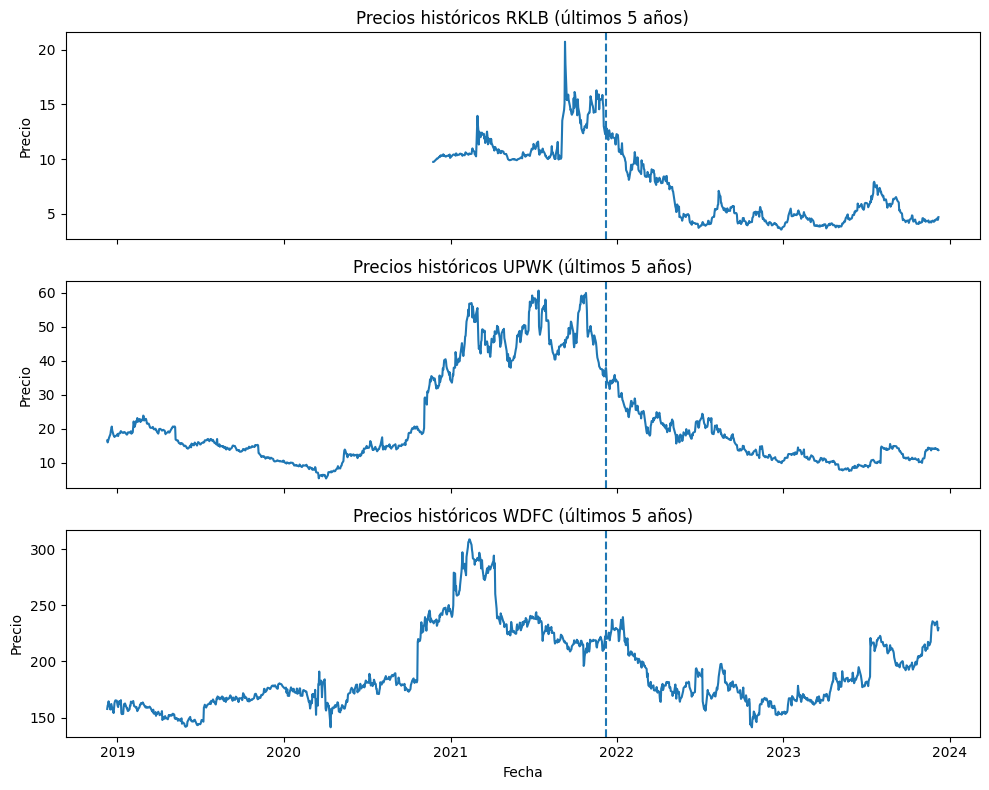

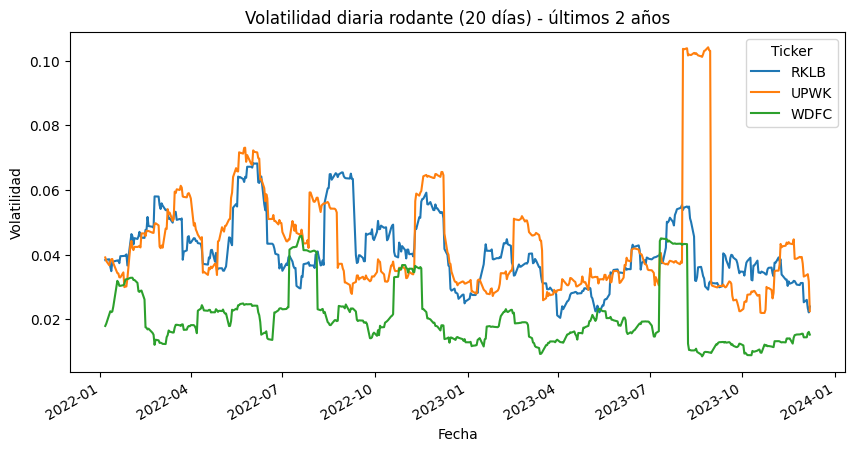

In [52]:
# BLOQUE 3 – Pregunta 3.1: Volatilidad histórica diaria (últimos 2 años)
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 1) Fechas según enunciado (últimos 5 años hasta HOY)
# -------------------------------------------------------------
hoy = datetime(2023, 12, 8)  # fecha fija pedida en el enunciado

end_hist = hoy.strftime("%Y-%m-%d")                # fin: HOY
start_5y = (hoy - pd.DateOffset(years=5)).strftime("%Y-%m-%d")  # inicio: hace 5 años
start_2y = (hoy - pd.DateOffset(years=2)).strftime("%Y-%m-%d")  # inicio últimos 2 años

print("Rango 5 años:", start_5y, "→", end_hist)
print("Rango 2 años:", start_2y, "→", end_hist)

# -------------------------------------------------------------
# 2) Precios para los últimos 5 años
# -------------------------------------------------------------
# tickers: lista de activos, por ejemplo ["AAPL", "MSFT", "TSLA"]
prices_5y = get_adj_close(tickers, start_5y, end_hist)

# Ordenar por fecha por si acaso
prices_5y = prices_5y.sort_index()

# De los 5 años, nos quedamos con los últimos 2 para el cálculo de volatilidad
prices_2y = prices_5y.loc[start_2y:]

# -------------------------------------------------------------
# 3) Rendimientos diarios (2 años)
# -------------------------------------------------------------
returns_2y = prices_2y.pct_change().dropna()

# -------------------------------------------------------------
# 4) Volatilidad diaria histórica (2 años)
# -------------------------------------------------------------
vol_daily_2y = returns_2y.std()

print("\nVolatilidad histórica diaria (últimos 2 años):")
print(vol_daily_2y)

# -------------------------------------------------------------
# 5) Gráfica de precios (últimos 5 años) para comparación de comportamiento
#    y marcamos con una línea vertical el inicio de los últimos 2 años
# -------------------------------------------------------------
fig, axes = plt.subplots(len(tickers), 1, figsize=(10, 8), sharex=True)

if len(tickers) == 1:
    axes = [axes]  # para que funcione igual con un solo ticker

for i, ticker in enumerate(tickers):
    axes[i].plot(prices_5y.index, prices_5y[ticker])
    # Línea vertical para marcar desde dónde se calculó la volatilidad (últimos 2 años)
    axes[i].axvline(pd.to_datetime(start_2y), linestyle="--")
    axes[i].set_title(f"Precios históricos {ticker} (últimos 5 años)")
    axes[i].set_ylabel("Precio")

axes[-1].set_xlabel("Fecha")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 6) Volatilidad rodante de 20 días (sobre los últimos 2 años)
# -------------------------------------------------------------
rolling_vol_20 = returns_2y.rolling(window=20).std()

rolling_vol_20.plot(figsize=(10, 5))
plt.title("Volatilidad diaria rodante (20 días) - últimos 2 años")
plt.ylabel("Volatilidad")
plt.xlabel("Fecha")
plt.show()


In [53]:
# BLOQUE 4 – Pregunta 4: Construcción del portafolio

import numpy as np

# Tickers de TU portafolio
tickers = ["RKLB", "UPWK", "WDFC"]

# Pesos del portafolio [RKLB, UPWK, WDFC]
# Sugerencia de pesos (ejemplo perfil moderado):
#   WDFC: 0.40 (menos volátil)
#   RKLB: 0.35 (intermedia)
#   UPWK: 0.25 (más volátil)
weights = np.array([0.35, 0.25, 0.40])

# Chequeo rápido para no hacer barbaridades
assert len(weights) == len(tickers), "Los pesos y los tickers no tienen la misma longitud."
assert np.isclose(weights.sum(), 1.0), "La suma de los pesos del portafolio debe ser 1."

# Asegurar orden de columnas
returns_2y = returns_2y[tickers]
returns_3y = returns_3y[tickers]

# Rendimientos diarios del portafolio usando 3 años
returns_port_3y = returns_3y @ weights

# Rendimientos diarios del portafolio solo en los últimos 2 años
returns_port_2y = returns_2y @ weights


Distribución inicial de 1,000,000 en el portafolio:
RKLB    350000.0
UPWK    250000.0
WDFC    400000.0
dtype: float64

Valor final del portafolio al final del periodo de 2 años:
640437.4110832678


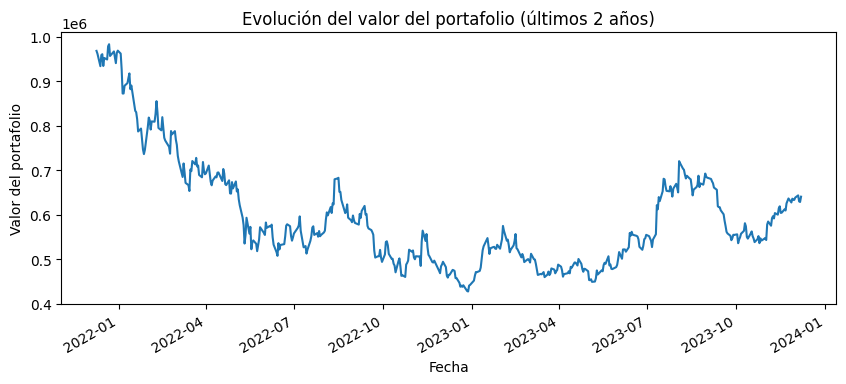

In [54]:
# BLOQUE 5 – Pregunta 5: Distribuir un millón de pesos en el portafolio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tickers y pesos del portafolio (mismos que en el BLOQUE 4)
tickers = ["RKLB", "UPWK", "WDFC"]
# Pesos [RKLB, UPWK, WDFC]
weights = np.array([0.35, 0.25, 0.40])

# Monto inicial invertido
inv_ini = 1_000_000

# Monto invertido en cada activo
asignacion = inv_ini * weights

# Serie con nombres de activos
dist_asignacion = pd.Series(asignacion, index=tickers)

print("Distribución inicial de 1,000,000 en el portafolio:")
print(dist_asignacion)

# Evolución del valor del portafolio en los últimos 2 años
# 'returns_port_2y' viene del BLOQUE 4 (rendimientos del portafolio)
valor_portafolio_2y = inv_ini * (1 + returns_port_2y).cumprod()

print("\nValor final del portafolio al final del periodo de 2 años:")
print(valor_portafolio_2y.iloc[-1])

# Gráfica de la evolución del valor del portafolio
valor_portafolio_2y.plot(figsize=(10, 4))
plt.title("Evolución del valor del portafolio (últimos 2 años)")
plt.ylabel("Valor del portafolio")
plt.xlabel("Fecha")
plt.show()


VaR diario histórico (95%) de cada activo (últimos 2 años):
Ticker
RKLB    0.069704
UPWK    0.063462
WDFC    0.029753
dtype: float64


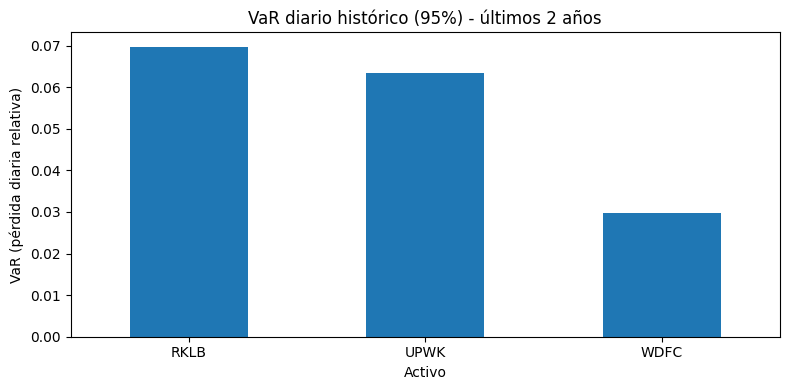

In [55]:
# BLOQUE 6 – Pregunta 6: VaR diario de los activos individuales (2 años)

import numpy as np
import matplotlib.pyplot as plt

# Tickers con los que venimos trabajando
tickers = ["RKLB", "UPWK", "WDFC"]

# returns_2y ya debe ser un DataFrame con esos activos como columnas
returns_2y = returns_2y[tickers]

def historical_var(returns, alpha=0.95):
    """
    VaR histórico al nivel alpha.
    Retorna un número positivo que representa pérdida.

    PARÁMETROS CLAVE:
    - returns: serie de rendimientos (activo individual).
    - alpha: nivel de confianza.
        * alpha=0.95 -> VaR al 95% (percentil 5% de la cola izquierda).
        * alpha=0.99 -> más conservador.
    """
    q = np.quantile(returns, 1 - alpha)
    return -q  # reportamos VaR como número positivo de pérdida

# Nivel de confianza según perfil de riesgo
# Perfil moderado: 95%; si fueras muy conservador, usarías 0.99
alpha_var = 0.95

# VaR diario histórico para cada activo usando 2 años de datos
VaR_individual_2y = returns_2y.apply(historical_var, alpha=alpha_var)

print(f"VaR diario histórico ({int(alpha_var*100)}%) de cada activo (últimos 2 años):")
print(VaR_individual_2y)

# Gráfica comparando el VaR de los activos seleccionados
plt.figure(figsize=(8, 4))
VaR_individual_2y.plot(kind="bar")
plt.title(f"VaR diario histórico ({int(alpha_var*100)}%) - últimos 2 años")
plt.ylabel("VaR (pérdida diaria relativa)")
plt.xlabel("Activo")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Primeros valores del VaR paramétrico diario (95%) del portafolio (EWMA):
Date
2021-12-09    52837.612703
2021-12-10    51299.410508
2021-12-13    51085.693835
2021-12-14    50685.087993
2021-12-15    49147.699735
dtype: float64


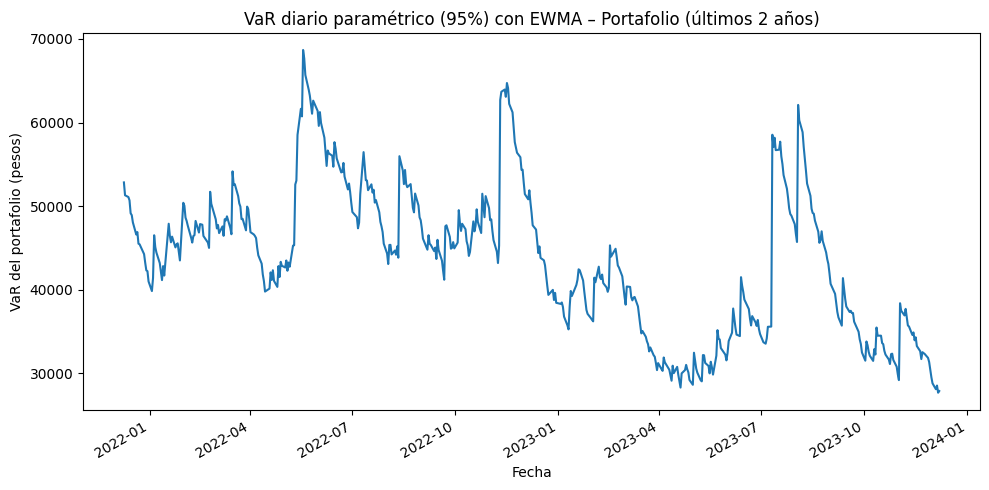

In [56]:
# BLOQUE 7 – Pregunta 7: VaR diario del portafolio (últimos 2 años)
# Método paramétrico con volatilidad EWMA, igual que en el Excel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tickers y pesos del portafolio (mismos que en bloques 4 y 5)
tickers = ["RKLB", "UPWK", "WDFC"]
weights = np.array([0.35, 0.25, 0.40])

# Nos aseguramos de usar solo esos activos y en ese orden
returns_2y = returns_2y[tickers]

# Rendimientos diarios del portafolio en los últimos 2 años
returns_port_2y = returns_2y @ weights      # Serie (índice = fechas)

# Parámetros del modelo de riesgo (mismo espíritu que en el Excel)
lambda_ewma = 0.94      # pon 0.95 si así dejaste el Excel
alpha = 0.95
z_alpha = 1.645         # cuantil 95% de la Normal estándar
capital = 1_000_000     # un millón de pesos

def ewma_sigma(returns: pd.Series, lam: float = 0.94) -> pd.Series:
    """
    Calcula la serie de volatilidades diarias EWMA (sigma_t) a partir
    de una serie de rendimientos.
    """
    r = returns.values
    var = np.zeros_like(r)
    var[0] = r[0]**2
    for t in range(1, len(r)):
        var[t] = lam * var[t-1] + (1 - lam) * r[t]**2
    sigma = np.sqrt(var)
    return pd.Series(sigma, index=returns.index)

# Volatilidad EWMA del portafolio
sigma_port_ewma = ewma_sigma(returns_port_2y, lam=lambda_ewma)

# VaR paramétrico diario (en pesos) usando la volatilidad EWMA
var_port_diario = z_alpha * sigma_port_ewma * capital

print("Primeros valores del VaR paramétrico diario (95%) del portafolio (EWMA):")
print(var_port_diario.head())

# (Opcional) VaR como proporción del portafolio, por si quieres ver 0.03 = 3%, etc.
var_port_pct = z_alpha * sigma_port_ewma

# Gráfica del VaR del portafolio en pesos
plt.figure(figsize=(10, 5))
var_port_diario.plot()
plt.title("VaR diario paramétrico (95%) con EWMA – Portafolio (últimos 2 años)")
plt.ylabel("VaR del portafolio (pesos)")
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()


In [57]:
# BLOQUE 9 – Preguntas 8 y 9: Betas individuales y beta del portafolio

import numpy as np
import pandas as pd

# Tickers y pesos del portafolio (mismos que en los bloques anteriores)
tickers = ["RKLB", "UPWK", "WDFC"]
weights = np.array([0.35, 0.25, 0.40])

# Aseguramos que returns_2y tenga solo estos activos y en este orden
returns_2y = returns_2y[tickers]

# -------------------------------------------------------------
# 1) Índice de mercado: S&P 500 en el mismo periodo de 2 años
#    (start_2y y end_hist ya fueron definidos con hoy = 2023-12-08)
# -------------------------------------------------------------
sp500 = get_adj_close("^GSPC", start_2y, end_hist)
sp500 = sp500.sort_index()

# Rendimientos diarios del índice
sp500_returns = sp500["^GSPC"].pct_change().dropna()

# -------------------------------------------------------------
# 2) Alinear fechas de activos y mercado
# -------------------------------------------------------------
data_beta = pd.concat([returns_2y, sp500_returns], axis=1).dropna()
data_beta.columns = tickers + ["SP500"]

# -------------------------------------------------------------
# 3) Matriz de covarianzas y varianza del mercado
# -------------------------------------------------------------
cov_matrix = data_beta.cov()
var_mkt = cov_matrix.loc["SP500", "SP500"]

# -------------------------------------------------------------
# 4) Betas individuales
#    beta_i = Cov(R_i, R_m) / Var(R_m)
# -------------------------------------------------------------
betas_ind = cov_matrix.loc[tickers, "SP500"] / var_mkt

print("Betas individuales respecto al S&P 500 (últimos 2 años):")
print(betas_ind)

# -------------------------------------------------------------
# 5) Beta del portafolio como combinación ponderada
#    beta_port = sum_i w_i * beta_i
# -------------------------------------------------------------
beta_port_comb = np.dot(weights, betas_ind.values)

# Por si no existiera ya returns_port_2y, lo recalculamos:
returns_port_2y = returns_2y @ weights

# -------------------------------------------------------------
# 6) Beta del portafolio por covarianza directa
# -------------------------------------------------------------
port_vs_mkt = pd.concat([returns_port_2y, sp500_returns], axis=1).dropna()
port_vs_mkt.columns = ["Portafolio", "SP500"]

beta_port_direct = port_vs_mkt.cov().loc["Portafolio", "SP500"] / var_mkt

print("\nBeta del portafolio (ponderando betas individuales):", beta_port_comb)
print("Beta del portafolio (directa por covarianza):      ", beta_port_direct)


[*********************100%***********************]  1 of 1 completed

Betas individuales respecto al S&P 500 (últimos 2 años):
RKLB    1.912692
UPWK    1.908531
WDFC    0.642127
Name: SP500, dtype: float64

Beta del portafolio (ponderando betas individuales): 1.4034260040200068
Beta del portafolio (directa por covarianza):       1.403426004020007



### Justificación de los criterios de medias móviles por acción

Para el análisis de las tres acciones **RKLB**, **UPWK** y **WDFC** en los próximos dos años, se definieron criterios específicos de medias móviles en función de su nivel de volatilidad histórica y del perfil de riesgo moderado del inversionista.

#### 1. RKLB – EMA de 20 días

En el caso de **RKLB**, la volatilidad observada es intermedia dentro del conjunto de activos.  
Se eligió una **media móvil exponencial (EMA)** con **ventana de 20 días** porque:

- La EMA otorga **mayor peso a los datos más recientes**, lo que permite reaccionar con rapidez ante cambios en la tendencia del precio.
- Una ventana de 20 días equivale aproximadamente a **un mes de operación**, lo que equilibra sensibilidad y filtrado de ruido.
- Para un perfil de riesgo moderado, es razonable capturar movimientos recientes sin utilizar ventanas demasiado cortas que generen señales excesivamente erráticas.

#### 2. UPWK – WMA de 20 días

**UPWK** presenta la **mayor volatilidad** de las tres acciones.  
Se optó por una **media móvil ponderada (WMA)** con **ventana de 20 días** por las siguientes razones:

- La WMA también asigna **más peso a la información reciente**, pero mantiene una estructura de ponderación lineal que suaviza ligeramente más que la EMA en algunos escenarios.
- La ventana de 20 días permite seguir la dinámica de corto plazo sin amplificar demasiado los movimientos extremos que caracterizan a este activo.
- Este criterio es consistente con la idea de **vigilar de cerca** un activo volátil, pero evitando que el análisis se contamine en exceso por saltos aislados de precio.

#### 3. WDFC – SMA de 60 días

Para **WDFC**, la acción con **menor volatilidad** del conjunto, se eligió una **media móvil simple (SMA)** de **60 días**:

- La SMA asigna **el mismo peso a todos los datos de la ventana**, lo que genera una señal más estable y apropiada para activos relativamente defensivos.
- Una ventana de 60 días (alrededor de **tres meses de operación**) permite enfocarse en la **tendencia de mediano plazo**, reduciendo el impacto de fluctuaciones de corto plazo poco relevantes.
- Dado el papel de WDFC como componente más estable del portafolio, una media móvil más larga y suave es coherente con un enfoque de **riesgo moderado** y con un horizonte de análisis de varios meses.

#### 4. Coherencia con el perfil de riesgo

En conjunto:

- Las acciones más volátiles (**UPWK** y, en menor medida, **RKLB**) utilizan medias móviles que **reaccionan con mayor rapidez** a nueva información (EMA y WMA de 20 días).
- La acción más estable (**WDFC**) utiliza una media móvil **más lenta y suavizada** (SMA 60 días), alineada con su rol de estabilizar el portafolio.
- Estos criterios permiten que el análisis técnico posterior refleje de forma coherente el **riesgo relativo de cada activo** y el **perfil de riesgo moderado** del inversionista.
"""))


Criterios de medias móviles para análisis posterior (próximos 2 años):

- RKLB: EMA con ventana/span = 20 días
- UPWK: WMA con ventana/span = 20 días
- WDFC: SMA con ventana/span = 60 días


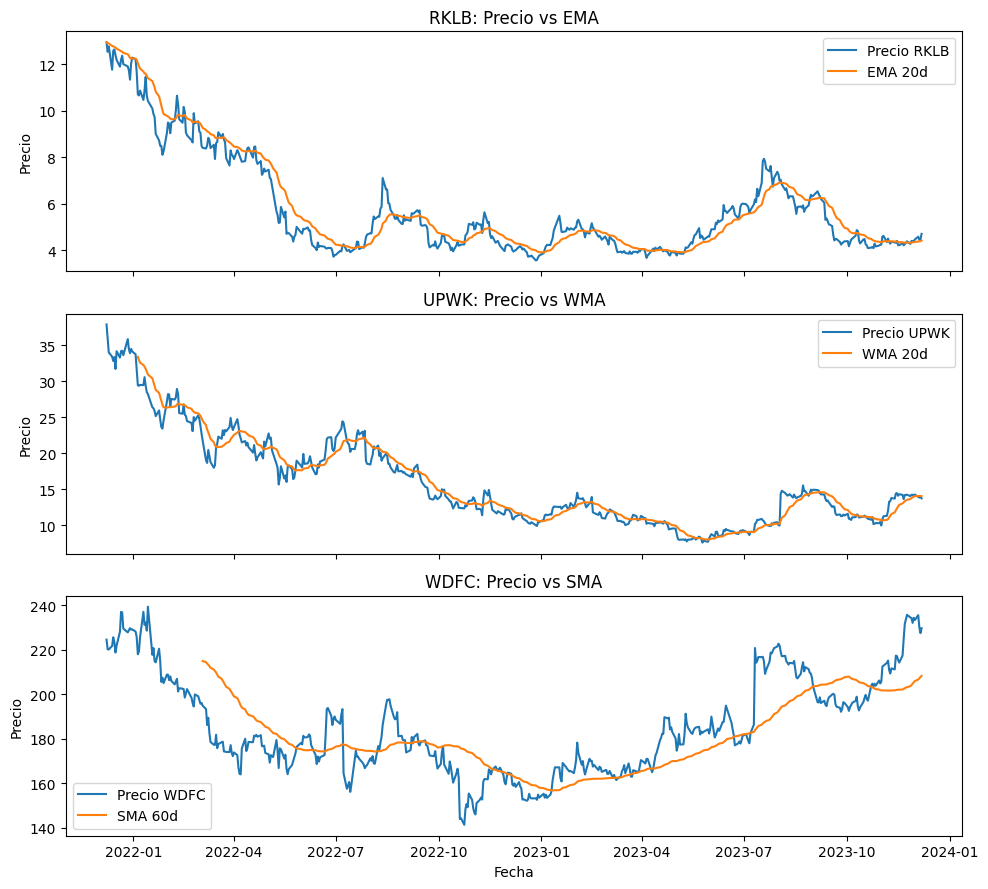

In [58]:
# BLOQUE 10 – Pregunta 10: Criterios SMA / WMA / EMA por acción

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Datos base: se asume que ya existen de bloques anteriores:
#   - tickers  = ["RKLB", "UPWK", "WDFC"]
#   - prices_2y: precios de cierre ajustados de los últimos 2 años
#                (desde start_2y hasta el 2023-12-08)
# ------------------------------------------------------------------
tickers = ["RKLB", "UPWK", "WDFC"]
prices_2y = prices_2y[tickers].sort_index()

# ------------------------------------------------------------------
# 1) Definición de funciones de medias móviles
# ------------------------------------------------------------------

def sma(series, window):
    """Simple Moving Average (SMA). Igual peso a todos los días."""
    return series.rolling(window=window).mean()

def wma(series, window):
    """
    Weighted Moving Average (WMA).
    Más peso a los días más recientes de la ventana.
    """
    weights = np.arange(1, window + 1)
    return series.rolling(window=window).apply(
        lambda x: np.dot(x, weights) / weights.sum(),
        raw=True
    )

def ema(series, span):
    """Exponential Moving Average (EMA). Decae exponencialmente."""
    return series.ewm(span=span, adjust=False).mean()

# ------------------------------------------------------------------
# 2) Criterios por acción (para usar en el monitoreo de los SIGUIENTES 2 AÑOS)
#    Aquí los aplicamos sobre los últimos 2 años para ilustrar.
#
# Justificación resumida:
#   - RKLB (volatilidad intermedia):
#         EMA 20 días -> responde relativamente rápido a cambios de tendencia.
#   - UPWK (más volátil):
#         WMA 20 días -> pondera más la info reciente pero suaviza un poco el ruido.
#   - WDFC (menos volátil, perfil más defensivo):
#         SMA 60 días -> visión de tendencia de mediano plazo, menos ruido.
# ------------------------------------------------------------------

ma_config = {
    "RKLB": {"tipo": "EMA", "param": 20},
    "UPWK": {"tipo": "WMA", "param": 20},
    "WDFC": {"tipo": "SMA", "param": 60},
}

# DataFrame para guardar las medias móviles
ma_df = pd.DataFrame(index=prices_2y.index)

for ticker in tickers:
    cfg = ma_config[ticker]
    if cfg["tipo"] == "SMA":
        ma_df[ticker] = sma(prices_2y[ticker], window=cfg["param"])
    elif cfg["tipo"] == "WMA":
        ma_df[ticker] = wma(prices_2y[ticker], window=cfg["param"])
    elif cfg["tipo"] == "EMA":
        ma_df[ticker] = ema(prices_2y[ticker], span=cfg["param"])
    else:
        raise ValueError(f"Tipo de media no reconocido para {ticker}: {cfg['tipo']}")

# ------------------------------------------------------------------
# 3) Impresión rápida de los criterios para documentar en el reporte
# ------------------------------------------------------------------
print("Criterios de medias móviles para análisis posterior (próximos 2 años):\n")
for ticker in tickers:
    cfg = ma_config[ticker]
    print(f"- {ticker}: {cfg['tipo']} con ventana/span = {cfg['param']} días")

# ------------------------------------------------------------------
# 4) Gráficas: precio histórico (2 años) + media móvil elegida por acción
# ------------------------------------------------------------------
fig, axes = plt.subplots(len(tickers), 1, figsize=(10, 9), sharex=True)

if len(tickers) == 1:
    axes = [axes]

for i, ticker in enumerate(tickers):
    axes[i].plot(prices_2y.index, prices_2y[ticker], label=f"Precio {ticker}")
    axes[i].plot(ma_df.index, ma_df[ticker],
                 label=f"{ma_config[ticker]['tipo']} {ma_config[ticker]['param']}d")
    axes[i].set_ylabel("Precio")
    axes[i].set_title(f"{ticker}: Precio vs {ma_config[ticker]['tipo']}")
    axes[i].legend()

axes[-1].set_xlabel("Fecha")
plt.tight_layout()
plt.show()



### Justificación del uso de MACD y RSI por acción

Para el análisis del portafolio compuesto por **RKLB**, **UPWK** y **WDFC** se seleccionaron indicadores de momento distintos por activo, buscando que cada uno refleje adecuadamente su nivel de volatilidad y su rol dentro del portafolio. En particular, se combinan **MACD** (para seguimiento de tendencia) y **RSI** (para medir sobrecompra/sobreventa).

---

#### 1. RKLB – MACD (12, 26, 9)

**Indicador elegido:** MACD con parámetros estándar (**EMA rápida 12 días, EMA lenta 26 días, señal 9 días**).

**Motivos de la elección:**

- RKLB presenta una **volatilidad intermedia**, con movimientos relevantes pero no tan extremos como UPWK.
- El MACD permite **detectar cambios de tendencia** combinando dos medias móviles exponenciales:
  - La EMA de 12 días reacciona rápido a los cambios recientes.
  - La EMA de 26 días recoge la tendencia de corto–mediano plazo.
- La línea de señal de 9 días suaviza el MACD y ayuda a generar señales operativas (cruces MACD–señal) sin generar demasiadas falsas alarmas.
- Para un perfil de riesgo moderado, estos parámetros son un estándar razonable: reaccionan con agilidad, pero manteniendo un nivel de filtrado aceptable.

En resumen, en RKLB se prioriza **seguir la dirección de la tendencia** y los cambios de momento, más que detectar puntos extremos de precio.

---

#### 2. UPWK – RSI de 14 días

**Indicador elegido:** RSI con **ventana de 14 días** (configuración clásica).

**Motivos de la elección:**

- UPWK es el activo con **mayor volatilidad** del portafolio, con movimientos diarios fuertes y episodios de picos pronunciados.
- El RSI es adecuado para activos muy volátiles porque:
  - Permite identificar zonas de **sobrecompra** (RSI ≈ 70) y **sobreventa** (RSI ≈ 30).
  - Ayuda a evitar entrar tarde en movimientos impulsivos, o vender en mínimos después de caídas bruscas.
- La ventana de 14 días es el estándar más utilizado:
  - Equilibra sensibilidad y estabilidad, capturando la dinámica de las últimas 2–3 semanas de mercado.
  - Genera señales útiles sin que el indicador se vuelva excesivamente errático.

En UPWK se busca principalmente **controlar el timing de entrada y salida** en un activo muy sensible, usando RSI para no sobrerreaccionar a movimientos extremos.

---

#### 3. WDFC – RSI de 21 días

**Indicador elegido:** RSI con **ventana de 21 días**.

**Motivos de la elección:**

- WDFC es la acción **menos volátil** del conjunto y se comporta como componente más defensivo del portafolio.
- En este contexto interesa más una lectura **suavizada y de mediano plazo** que señales de corto plazo muy frecuentes.
- Aumentar la ventana del RSI de 14 a **21 días**:
  - Reduce el ruido de variaciones pequeñas en el precio.
  - Hace que las señales de sobrecompra/sobreventa sean más excepcionales y, en principio, más relevantes.
- El mismo umbral conceptual (70 sobrecompra / 30 sobreventa) se mantiene, pero con **criterios más exigentes** para que el indicador solo marque niveles extremos cuando el movimiento realmente sea significativo para un activo de baja volatilidad.

En WDFC el RSI de 21 días sirve para detectar **oportunidades de acumulación o toma de utilidades** en un activo estable, sin sobrecargar el análisis con demasiadas señales.

---

### Conclusión

- **RKLB:** MACD (12, 26, 9) para seguir la **tendencia y el cambio de momento** en un activo de volatilidad intermedia.  
- **UPWK:** RSI 14 días para controlar **sobrecompra/sobreventa de corto plazo** en el activo más volátil del portafolio.  
- **WDFC:** RSI 21 días para detectar **extremos más robustos** en un activo defensivo y menos volátil.

Los parámetros elegidos son coherentes con el **perfil de riesgo moderado** y complementan el análisis de medias móviles implementado en el bloque anterior.



Criterios para implementar MACD/RSI en el portafolio:

- RKLB: MACD con EMA rápida=12 días, EMA lenta=26 días y señal=9 días.
- UPWK: RSI con ventana de 14 días (sobrecompra ~70, sobreventa ~30).
- WDFC: RSI con ventana de 21 días (sobrecompra ~70, sobreventa ~30).


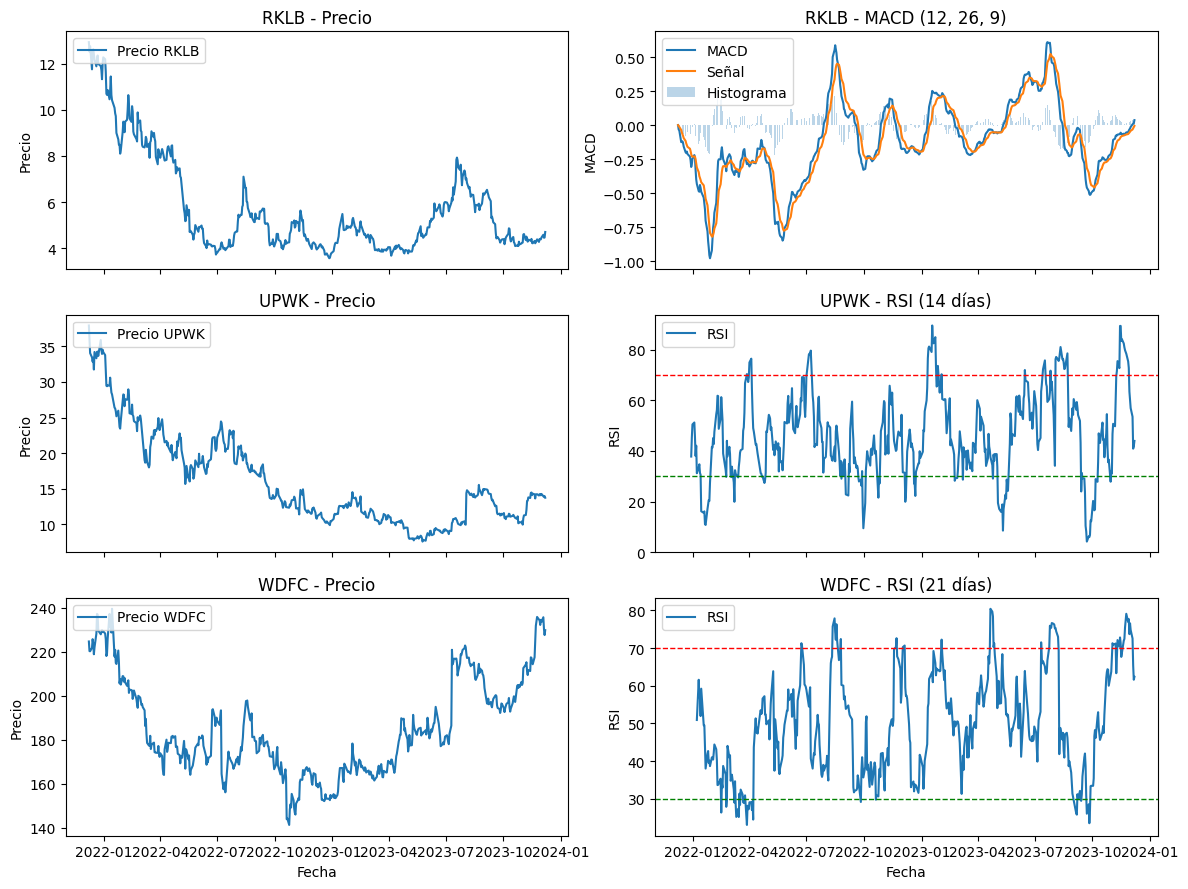

In [59]:
# BLOQUE 11 – Pregunta 11: Criterios para MACD / RSI por acción y gráfica

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Datos base:
#   - tickers  = ["RKLB", "UPWK", "WDFC"]
#   - prices_2y: precios de cierre ajustados de los últimos 2 años
# ------------------------------------------------------------------
tickers = ["RKLB", "UPWK", "WDFC"]
prices_2y = prices_2y[tickers].sort_index()

# ------------------------------------------------------------------
# 1) Funciones auxiliares: EMA, MACD y RSI
# ------------------------------------------------------------------

def ema(series, span):
    """Exponential Moving Average (EMA)."""
    return series.ewm(span=span, adjust=False).mean()

def macd(series, fast=12, slow=26, signal=9):
    """
    MACD clásico:
      - Línea MACD  = EMA(fast) - EMA(slow)
      - Señal       = EMA(MACD, signal)
      - Histograma  = MACD - Señal
    """
    ema_fast = ema(series, span=fast)
    ema_slow = ema(series, span=slow)
    macd_line = ema_fast - ema_slow
    signal_line = ema(macd_line, span=signal)
    hist = macd_line - signal_line

    out = pd.DataFrame(index=series.index)
    out["MACD"] = macd_line
    out["Signal"] = signal_line
    out["Hist"] = hist
    return out

def rsi(series, window=14):
    """
    Relative Strength Index (RSI) clásico.
    Devuelve valores entre 0 y 100.
    """
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi_vals = 100 - (100 / (1 + rs))
    return rsi_vals

# ------------------------------------------------------------------
# 2) Criterios por acción para MACD / RSI
# ------------------------------------------------------------------
# Justificación (resumen):
# - RKLB: volatilidad intermedia -> MACD estándar 12-26-9
#         para seguir cambios de tendencia de corto–mediano plazo.
# - UPWK: activo más volátil -> RSI 14 días
#         para detectar zonas de sobrecompra/sobreventa y ajustar timing.
# - WDFC: activo defensivo, menos volátil -> RSI 21 días
#         enfoque más de mediano plazo, señales más estables.

indicator_config = {
    "RKLB": {
        "tipo": "MACD",
        "params": {"fast": 12, "slow": 26, "signal": 9},
    },
    "UPWK": {
        "tipo": "RSI",
        "params": {"window": 14},
    },
    "WDFC": {
        "tipo": "RSI",
        "params": {"window": 21},
    },
}

# ------------------------------------------------------------------
# 3) Cálculo de indicadores por acción
# ------------------------------------------------------------------
macd_dict = {}
rsi_dict = {}

for ticker in tickers:
    cfg = indicator_config[ticker]
    price_series = prices_2y[ticker]

    if cfg["tipo"] == "MACD":
        p = cfg["params"]
        macd_dict[ticker] = macd(
            price_series,
            fast=p["fast"],
            slow=p["slow"],
            signal=p["signal"],
        )
    elif cfg["tipo"] == "RSI":
        p = cfg["params"]
        rsi_dict[ticker] = rsi(price_series, window=p["window"])
    else:
        raise ValueError(f"Tipo de indicador no reconocido para {ticker}: {cfg['tipo']}")

# ------------------------------------------------------------------
# 4) Impresión de criterios para documentar en el reporte
# ------------------------------------------------------------------
print("Criterios para implementar MACD/RSI en el portafolio:\n")
for ticker in tickers:
    cfg = indicator_config[ticker]
    if cfg["tipo"] == "MACD":
        p = cfg["params"]
        print(
            f"- {ticker}: MACD con EMA rápida={p['fast']} días, "
            f"EMA lenta={p['slow']} días y señal={p['signal']} días."
        )
    else:
        p = cfg["params"]
        print(
            f"- {ticker}: RSI con ventana de {p['window']} días "
            f"(sobrecompra ~70, sobreventa ~30)."
        )

# ------------------------------------------------------------------
# 5) Gráficas: para cada acción, precio + indicador (MACD o RSI)
# ------------------------------------------------------------------
fig, axes = plt.subplots(len(tickers), 2, figsize=(12, 9), sharex=True)

if len(tickers) == 1:
    axes = np.array([axes])

for i, ticker in enumerate(tickers):
    cfg = indicator_config[ticker]
    price_series = prices_2y[ticker]

    # Columna izquierda: precios
    ax_price = axes[i, 0]
    ax_price.plot(price_series.index, price_series, label=f"Precio {ticker}")
    ax_price.set_ylabel("Precio")
    ax_price.set_title(f"{ticker} - Precio")
    ax_price.legend(loc="upper left")

    # Columna derecha: indicador
    ax_ind = axes[i, 1]
    if cfg["tipo"] == "MACD":
        macd_df = macd_dict[ticker]
        ax_ind.plot(macd_df.index, macd_df["MACD"], label="MACD")
        ax_ind.plot(macd_df.index, macd_df["Signal"], label="Señal")
        ax_ind.bar(
            macd_df.index,
            macd_df["Hist"],
            label="Histograma",
            alpha=0.3,
        )
        ax_ind.set_title(f"{ticker} - MACD ({cfg['params']['fast']}, {cfg['params']['slow']}, {cfg['params']['signal']})")
        ax_ind.set_ylabel("MACD")
        ax_ind.legend(loc="upper left")

    elif cfg["tipo"] == "RSI":
        rsi_series = rsi_dict[ticker]
        ax_ind.plot(rsi_series.index, rsi_series, label="RSI")
        ax_ind.axhline(70, color="red", linestyle="--", linewidth=1)
        ax_ind.axhline(30, color="green", linestyle="--", linewidth=1)
        ax_ind.set_title(f"{ticker} - RSI ({cfg['params']['window']} días)")
        ax_ind.set_ylabel("RSI")
        ax_ind.legend(loc="upper left")

axes[-1, 0].set_xlabel("Fecha")
axes[-1, 1].set_xlabel("Fecha")
plt.tight_layout()
plt.show()


In [60]:
# BLOQUE 13 – CAPM igual a Excel (arregla el tema de 503 vs 504)

import numpy as np
import pandas as pd

HOY = pd.Timestamp(2023, 12, 8)
tickers = ["RKLB", "UPWK", "WDFC"]
weights = np.array([0.35, 0.25, 0.40])

inv_ini = 1_000_000
Dias_al_anio = 252
N = 504

E_rf_diario = 0.0

# 1) Descargar con BUFFER para no quedarnos cortos por días faltantes
start_2y_buf = HOY - pd.DateOffset(years=2) - pd.tseries.offsets.BDay(10)
end_inclusive = HOY + pd.Timedelta(days=1)  # end exclusivo en yfinance, sumamos 1 día

prices_assets = get_adj_close(tickers, start_2y_buf, end_inclusive).sort_index()
prices_sp500  = get_adj_close("^GSPC", start_2y_buf, end_inclusive).sort_index()

# 2) Alinear PRECIOS en un mismo calendario y rellenar huecos
prices = prices_assets.join(prices_sp500, how="outer")  # calendario unión
prices = prices.sort_index().ffill()                    # forward fill (como Excel suele “arrastrar”)
prices = prices.dropna()                                # por si al inicio todavía hay NaNs

# 3) Rendimientos (ya con calendario alineado)
ret = prices.pct_change().dropna()

# Filtrar columnas
ret_sp500 = ret["^GSPC"].rename("SP500")
ret_assets = ret[tickers]

# Portafolio
ret_port = (ret_assets @ weights).rename("R_port")

capm_df = pd.concat([ret_port, ret_sp500], axis=1).dropna()

# Quedarnos con últimos 504 (si hay más, cortamos; si hay menos, mostramos cuántos hay)
if len(capm_df) < N:
    print(f"AVISO: solo hay {len(capm_df)} rendimientos disponibles (no {N}). Se usa ese tamaño.")
    N_use = len(capm_df)
else:
    N_use = N

capm_df = capm_df.tail(N_use)

# 4) Estadísticos tipo Excel (muestral: ddof=1)
E_Rm_diario = float(capm_df["SP500"].mean())
Var_SP500 = float(capm_df["SP500"].var(ddof=1))               # VAR.S
Cov_Rport_SP500 = float(capm_df["R_port"].cov(capm_df["SP500"]))  # COVARIANZA.M

Beta_portafolio = Cov_Rport_SP500 / Var_SP500

# 5) CAPM
market_premium = E_Rm_diario - E_rf_diario
E_Rp_diario = E_rf_diario + Beta_portafolio * market_premium

E_Rp_anual = (1 + E_Rp_diario)**Dias_al_anio - 1
E_Rp_2y = (1 + E_Rp_diario)**(2*Dias_al_anio) - 1

Valor_esperado_2y = inv_ini * (1 + E_Rp_2y)

print("r_f_diario", E_rf_diario)
print("E[R_m]_diario", E_Rm_diario)
print("Dias_al_anio", Dias_al_anio)
print()
print("Var_SP500", Var_SP500)
print("Cov(R_port,SP500)", Cov_Rport_SP500)
print("Beta_portafolio", Beta_portafolio)
print()
print("E[R_p]_diario_CAPM", E_Rp_diario)
print("E[R_p]_anual_CAPM", E_Rp_anual)
print("E[R_p]_2y_acum", E_Rp_2y)
print()
print("Valor_inicial", inv_ini)
print("Valor_esperado_2y_CAPM", Valor_esperado_2y)
print("N obs CAPM usadas:", len(capm_df))


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed

r_f_diario 0.0
E[R_m]_diario 4.04136272095988e-05
Dias_al_anio 252

Var_SP500 0.00015140086991596128
Cov(R_port,SP500) 0.0002126103324937898
Beta_portafolio 1.4042873902362933

E[R_p]_diario_CAPM 5.6752347084149956e-05
E[R_p]_anual_CAPM 0.014403936848713217
E[R_p]_2y_acum 0.029015347094168087

Valor_inicial 1000000
Valor_esperado_2y_CAPM 1029015.3470941681
N obs CAPM usadas: 504


[*********************100%***********************]  3 of 3 completed


HOY supuesto: 2025-12-08
Periodo analizado para señales: 2023-05-29 a 2025-12-29

ACTIVO: RKLB
Fechas de COMPRA (cruce alcista MA20 sobre MA60):
DatetimeIndex(['2023-08-23', '2023-12-11', '2024-05-21', '2025-05-07'], dtype='datetime64[ns]', name='Date', freq=None)
Fechas de VENTA (cruce bajista MA20 bajo MA60):
DatetimeIndex(['2023-08-29', '2024-02-08', '2025-02-28', '2025-11-20'], dtype='datetime64[ns]', name='Date', freq=None)

ACTIVO: UPWK
Fechas de COMPRA (cruce alcista MA20 sobre MA60):
DatetimeIndex(['2023-08-23', '2023-11-22', '2024-07-26', '2024-10-08',
               '2025-05-13', '2025-08-28', '2025-11-28'],
              dtype='datetime64[ns]', name='Date', freq=None)
Fechas de VENTA (cruce bajista MA20 bajo MA60):
DatetimeIndex(['2023-10-03', '2024-02-07', '2024-08-14', '2025-01-31',
               '2025-06-27', '2025-11-05'],
              dtype='datetime64[ns]', name='Date', freq=None)

ACTIVO: WDFC
Fechas de COMPRA (cruce alcista MA20 sobre MA60):
DatetimeIndex(['2023-08

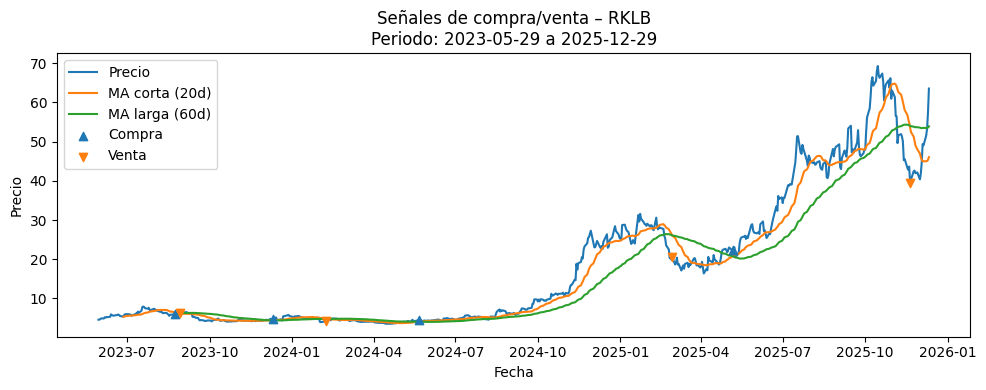

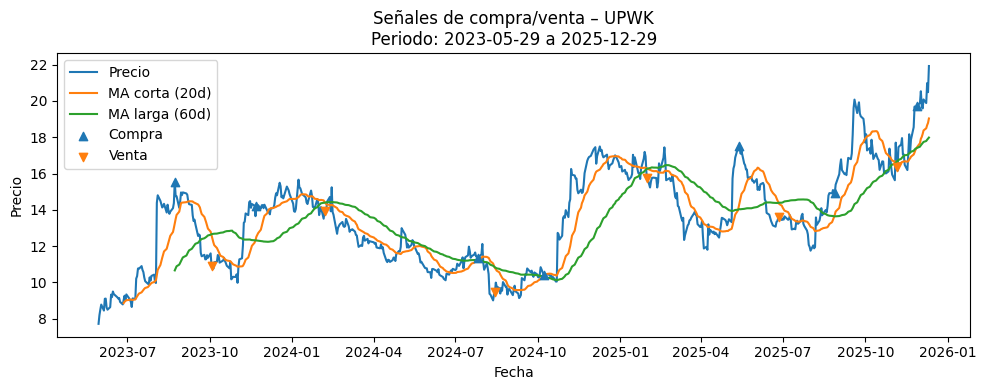

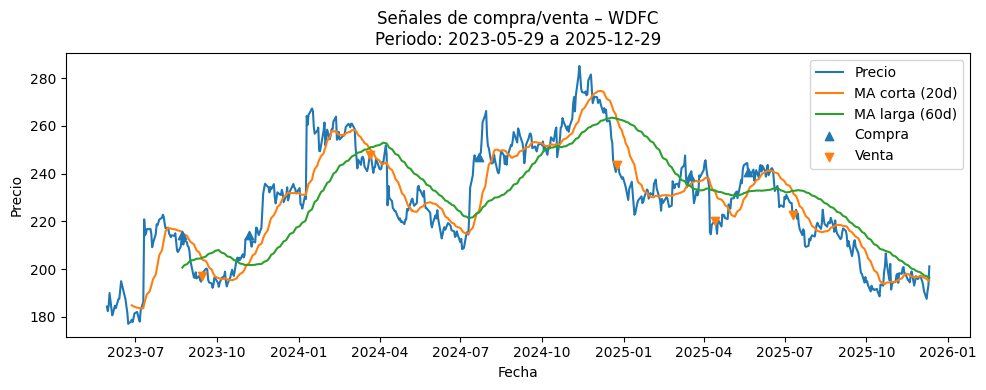

In [61]:
# BLOQUE 14 – Preguntas 14 y 15: Señales de compra/venta (medias móviles)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# ------------------------------------------------------------------
# Suponga que el día de HOY nuevamente es el 8 de diciembre de 2025
# ------------------------------------------------------------------
HOY_2025 = datetime(2025, 12, 8)

# Tickers del portafolio
tickers = ["RKLB", "UPWK", "WDFC"]

# Rango de fechas para generar señales:
#   del 29 de mayo de 2023 al 29 de diciembre de 2025
start_signals = "2023-05-29"
end_signals   = "2025-12-29"

# Descarga de precios para el rango elegido
prices_signals = get_adj_close(tickers, start_signals, end_signals)
prices_signals = prices_signals.sort_index()

# Parámetros de la estrategia de medias móviles
# ------------------------------------------------------------------
# Usamos una MA corta de 20 días y una larga de 60 días
# para tener señales consistentes con el horizonte de 2 años.
short_window = 20
long_window  = 60

def moving_average_signals(price_series, short_window=20, long_window=60):
    """
    Genera señales de compra/venta usando el cruce de dos medias móviles.

    - short_window: ventana de la media móvil corta.
    - long_window:  ventana de la media móvil larga.
      (Regla básica: long_window > short_window).
    """
    # Medias móviles
    short_ma = price_series.rolling(window=short_window).mean()
    long_ma  = price_series.rolling(window=long_window).mean()

    # signal = 1 cuando MA corta > MA larga (tendencia alcista)
    # signal = 0 en caso contrario
    signal = (short_ma > long_ma).astype(int)

    # Desfasamos un día para detectar los cambios de estado
    signal_shift = signal.shift(1)

    # Cruce alcista: 0 -> 1  (COMPRA)
    buy_signals = (signal == 1) & (signal_shift == 0)

    # Cruce bajista: 1 -> 0  (VENTA)
    sell_signals = (signal == 0) & (signal_shift == 1)

    return {
        "short_ma": short_ma,
        "long_ma": long_ma,
        "buy": buy_signals,
        "sell": sell_signals
    }

# Calculamos señales para cada ticker
# ------------------------------------------------------------------
signals = {}
for ticker in tickers:
    signals[ticker] = moving_average_signals(
        prices_signals[ticker],
        short_window=short_window,
        long_window=long_window
    )

# Mostrar fechas de compra/venta en el periodo
# ------------------------------------------------------------------
print(f"HOY supuesto: {HOY_2025.date()}")
print(f"Periodo analizado para señales: {start_signals} a {end_signals}")

for ticker in tickers:
    buys = prices_signals.index[signals[ticker]["buy"]]
    sells = prices_signals.index[signals[ticker]["sell"]]

    print(f"\nACTIVO: {ticker}")
    print("Fechas de COMPRA (cruce alcista MA20 sobre MA60):")
    print(buys)
    print("Fechas de VENTA (cruce bajista MA20 bajo MA60):")
    print(sells)

# Graficar precios con señales
# ------------------------------------------------------------------
for ticker in tickers:
    plt.figure(figsize=(10, 4))

    # Precio del activo
    plt.plot(prices_signals.index, prices_signals[ticker], label="Precio")

    # Medias móviles
    plt.plot(signals[ticker]["short_ma"].index,
             signals[ticker]["short_ma"],
             label=f"MA corta ({short_window}d)")
    plt.plot(signals[ticker]["long_ma"].index,
             signals[ticker]["long_ma"],
             label=f"MA larga ({long_window}d)")

    # Puntos de compra y venta
    buy_dates = prices_signals.index[signals[ticker]["buy"]]
    sell_dates = prices_signals.index[signals[ticker]["sell"]]

    plt.scatter(buy_dates,
                prices_signals.loc[buy_dates, ticker],
                marker="^", label="Compra", zorder=5)
    plt.scatter(sell_dates,
                prices_signals.loc[sell_dates, ticker],
                marker="v", label="Venta", zorder=5)

    plt.title(f"Señales de compra/venta – {ticker}\n"
              f"Periodo: {start_signals} a {end_signals}")
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.legend()
    plt.tight_layout()
    plt.show()


Rendimientos reales por activo (estrategia MA, periodo de señales):
RKLB    6.812449
UPWK   -0.258553
WDFC   -0.106544
dtype: float64

Rendimiento real del portafolio (estrategia MA, periodo completo): 2.277101582999231

Rendimiento esperado del portafolio por CAPM en el mismo periodo: 0.023800424449501145

Rendimiento real anualizado del portafolio (estrategia MA): 0.5981238476307451
Rendimiento esperado anualizado del portafolio (CAPM): 0.009333959339220987

Comparación de rendimientos:
                          Método  Rendimiento
0       CAPM (esperado, periodo)     0.023800
1  Estrategia MA (real, periodo)     2.277102
2              CAPM (anualizado)     0.009334
3     Estrategia MA (anualizado)     0.598124


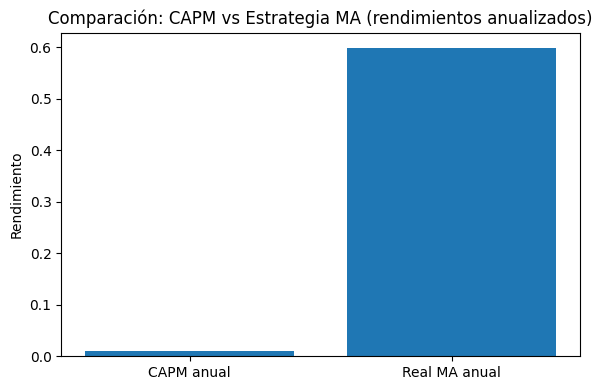

In [62]:
# BLOQUE 16 – Pregunta 16: Comparación CAPM vs rendimiento real del portafolio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Se asume que ya existen:
#   - tickers = ["RKLB", "UPWK", "WDFC"]
#   - weights = np.array([0.35, 0.25, 0.40])
#   - prices_signals: precios del periodo 2023-05-29 a 2025-12-29
#   - signals: diccionario con señales de compra/venta por ticker
#   - E_Rp_daily: rendimiento esperado diario del portafolio según CAPM
#                 calculado en el bloque 13

def compute_trade_return(price_series, signal_dict, initial_value=100):
    """
    Simula comprar en cada señal de compra y vender
    en la siguiente señal de venta. Multiplica el capital
    por (P_venta / P_compra) en cada trade.

    - price_series: serie de precios del activo (alineada con las señales).
    - signal_dict: diccionario con:
        * "buy": serie booleana (True en fechas de compra)
        * "sell": serie booleana (True en fechas de venta)
    - initial_value: capital inicial (normalizado).
    """
    buys_idx = np.where(signal_dict["buy"])[0]
    sells_idx = np.where(signal_dict["sell"])[0]

    value = initial_value
    j = 0  # índice de ventas

    for i in range(len(buys_idx)):
        buy_i = buys_idx[i]

        # Buscar la primera venta después de la compra
        while j < len(sells_idx) and sells_idx[j] <= buy_i:
            j += 1
        if j >= len(sells_idx):
            break

        sell_i = sells_idx[j]
        price_buy = price_series.iloc[buy_i]
        price_sell = price_series.iloc[sell_i]

        value *= (price_sell / price_buy)
        j += 1

    total_return = value / initial_value - 1
    return total_return

# 1) Rendimientos reales por activo usando la estrategia MA (inciso 15)
# ----------------------------------------------------------------------
real_returns_assets = {}
for ticker in tickers:
    real_returns_assets[ticker] = compute_trade_return(
        prices_signals[ticker],
        signals[ticker],
        initial_value=100
    )

real_returns_assets = pd.Series(real_returns_assets)

# 2) Rendimiento real del portafolio (mismos pesos del portafolio)
# ----------------------------------------------------------------------
real_portfolio_return = np.dot(weights, real_returns_assets.values)

print("Rendimientos reales por activo (estrategia MA, periodo de señales):")
print(real_returns_assets)

print("\nRendimiento real del portafolio (estrategia MA, periodo completo):",
      real_portfolio_return)

# 3) Rendimiento esperado del portafolio por CAPM en el MISMO periodo
# ----------------------------------------------------------------------
# Usamos E_Rp_daily (CAPM) y lo llevamos al horizonte
# cubierto por prices_signals (mismo tramo que la estrategia).
num_days_period = len(prices_signals.index)
E_Rp_period_CAPM = (1 + E_Rp_daily) ** num_days_period - 1

print("\nRendimiento esperado del portafolio por CAPM en el mismo periodo:",
      E_Rp_period_CAPM)

# 4) Opcional: anualizar ambos para comparar en términos anuales
# ----------------------------------------------------------------------
years_period = num_days_period / 252

real_portfolio_return_annual = (1 + real_portfolio_return) ** (1 / years_period) - 1
E_Rp_annual_CAPM = (1 + E_Rp_daily) ** 252 - 1

print("\nRendimiento real anualizado del portafolio (estrategia MA):",
      real_portfolio_return_annual)
print("Rendimiento esperado anualizado del portafolio (CAPM):",
      E_Rp_annual_CAPM)

# 5) Tabla de comparación
# ----------------------------------------------------------------------
comparison = pd.DataFrame({
    "Método": [
        "CAPM (esperado, periodo)",
        "Estrategia MA (real, periodo)",
        "CAPM (anualizado)",
        "Estrategia MA (anualizado)"
    ],
    "Rendimiento": [
        E_Rp_period_CAPM,
        real_portfolio_return,
        E_Rp_annual_CAPM,
        real_portfolio_return_annual
    ]
})

print("\nComparación de rendimientos:")
print(comparison)

# 6) Gráfica comparativa (solo anualizados para que se vea claro)
# ----------------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.bar(
    ["CAPM anual", "Real MA anual"],
    [E_Rp_annual_CAPM, real_portfolio_return_annual]
)
plt.title("Comparación: CAPM vs Estrategia MA (rendimientos anualizados)")
plt.ylabel("Rendimiento")
plt.tight_layout()
plt.show()
